# Using tf-idf approach to generate features

### Loading all the necessary packages for the subsequant analysis:

In [3]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC
from sklearn import linear_model
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from ipywidgets import widgets
from sklearn import svm
import pandas as pd
import numpy as np
import random
import string
import utils
import glob
import re

---

## Read in German stopwords:

This list helps to avoid gathering unneccessary words and thus improves the overall score.

In [4]:
stopword = pd.read_csv('/Users/torben/PycharmProjects/toolbox/data/stopwords/stopwords.csv', index_col=None, header=0)
stopword_u = pd.read_csv('/Users/torben/PycharmProjects/toolbox/data/stopwords/stopwordsupper.csv', index_col=None, header=0)
swl = [stopword,stopword_u]

In [5]:
stopword_list = pd.concat(swl)
stopwordlist = stopword_list['words'].values.tolist()

---
# Generate Test and Train Data

This for-loop goes through the gathered data and builds dataframes for further analysis.

## Train Data:

In [6]:
category = {
    1: 'politik', 2: 'wirtschaft', 3: 'finanzen', 4: 'feuilleton', 5: 'sport', 6: 'gesellschaft', 7: 'stil', 
    8: 'technik-motor', 9: 'wissen', 10: 'reise', 11: 'beruf-chance'
}

In [7]:
frames = []

for key, value in category.items():
    raw_faz = utils.train_tables(value)
    frames.append(raw_faz)
    faz_train = pd.concat(frames, axis=0, ignore_index=True)
    
faz_train = faz_train.drop_duplicates()

Split the train set in the four classes we aim to predict in the end (Politics, Sports, Economy and the rest)

In [8]:
faz_pol = faz_train.loc[faz_train['label'] == 'politik', ['title', 'detailed']]
faz_pol['goal_val'] = 1

faz_sport = faz_train.loc[faz_train['label'] == 'sport', ['title', 'detailed']]
faz_sport['goal_val'] = 2

faz_eco = faz_train.loc[faz_train['label'] == 'wirtschaft', ['title', 'detailed']]
faz_eco['goal_val'] = 3

faz_feu = faz_train.loc[faz_train['label'] == 'feuilleton', ['title', 'detailed']]
faz_feu['goal_val'] = 4

faz_fin = faz_train.loc[faz_train['label'] == 'finanzen', ['title', 'detailed']]
faz_fin['goal_val'] = 5

faz_ges = faz_train.loc[faz_train['label'] == 'gesellschaft', ['title', 'detailed']]
faz_ges['goal_val'] = 6

In [9]:
faz_train_2 = faz_train.copy()

faz_rem = faz_train_2.loc[(faz_train_2['label'].isin(['stil', 'technik-motor', 'wissen', 'reise', 'beruf-chance']), ['title', 'detailed'])]
faz_rem['goal_val'] = 0

In [10]:
train_conc = [faz_pol,faz_sport,faz_eco,faz_feu,faz_fin,faz_ges,faz_rem]
train = pd.concat(train_conc)

In [11]:
train_detailed = train.drop(columns=['title'])

Train Data ['title']:

In [12]:
train_titles = train.drop(columns=['detailed'])

In [13]:
train_titles = train_titles.rename(index=str, columns={"title": "detailed"})

Merge the two sets in order to obtain more data for the model's training:

In [14]:
combined = [train_detailed,train_titles]
training_data = pd.concat(combined)

---
Assign data to the respective variables.

In [15]:
X_train = training_data['detailed'].str.lower()

In [16]:
y_train = training_data['goal_val']

## Test Data:

In [17]:
frames = []

for key, value in category.items():
    raw_faz = utils.test_tables(value)
    frames.append(raw_faz)
    faz_test = pd.concat(frames, axis=0, ignore_index=True)
    
faz_test = faz_test.drop_duplicates()

In [18]:
faz_pol_t = faz_test.loc[faz_test['label'] == 'politik', ['detailed']]
faz_pol_t['goal_val'] = 1

faz_sport_t = faz_test.loc[faz_test['label'] == 'sport', ['detailed']]
faz_sport_t['goal_val'] = 2

faz_eco_t = faz_test.loc[faz_test['label'] == 'wirtschaft', ['detailed']]
faz_eco_t['goal_val'] = 3

faz_feu_t = faz_test.loc[faz_test['label'] == 'feuilleton', ['detailed']]
faz_feu_t['goal_val'] = 4

faz_fin_t = faz_test.loc[faz_test['label'] == 'finanzen', ['detailed']]
faz_fin_t['goal_val'] = 5

faz_ges_t = faz_test.loc[faz_test['label'] == 'gesellschaft', ['detailed']]
faz_ges_t['goal_val'] = 6

In [19]:
faz_test_2 = faz_test.copy()

faz_rem_t = faz_test_2.loc[(faz_test_2['label'].isin(['stil', 'technik-motor', 'wissen', 'reise', 'beruf-chance']), ['detailed'])]
faz_rem_t['goal_val'] = 0

In [20]:
test_conc = [faz_pol_t,faz_sport_t,faz_eco_t,faz_feu_t,faz_fin_t,faz_ges_t,faz_rem_t]
testing_data = pd.concat(test_conc)

---
Assign data to the respective variables.

In [21]:
X_test = testing_data['detailed'].str.lower()

In [22]:
y_test = testing_data['goal_val']

---

## Get an idea of how much articles we collected & how they are distributed over the test and trainings sets:

In [23]:
print("# of entries - Training dataset: ", X_train.shape[0])
print("# of entries - Test dataset: ", X_test.shape[0])

# of entries - Training dataset:  6344
# of entries - Test dataset:  563


In [24]:
print('Trainset:')
print(training_data.goal_val.value_counts())
print('\n')
print('Testset:')
print(testing_data.goal_val.value_counts())

Trainset:
1    1490
2    1256
3    1016
6     826
0     700
4     596
5     460
Name: goal_val, dtype: int64


Testset:
0    116
1    107
2     91
3     76
6     67
4     57
5     49
Name: goal_val, dtype: int64


---
## Build a feature vector with the help of the TF-IDF Vectorizer:

In [25]:
tf_vector = TfidfVectorizer(stop_words=stopwordlist,
                            analyzer='word',
                            ngram_range=(1,3),
                            max_features=10000, 
                            use_idf=True,
                            smooth_idf=True,
                           )

train = tf_vector.fit_transform(X_train)
test = tf_vector.transform(X_test)

/anaconda3/envs/toolbox/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aussen', 'ausserhalb', 'dat', 'dreissig', 'einigermassen', 'gewissermassen', 'inf', 'müsst', 'regelmässig', 'schliesslich', 'weiss', 'zb'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


---
### Apply Linear SupportVectorMachines with new feature vector:

In [27]:
lclf = LinearSVC( 
    tol=1e-5, 
    loss='hinge')

lclf.fit(train, y_train) 
pred = lclf.predict(test)
test_accuracy = accuracy_score(y_test, pred)

---
---
### Build a wordcloud for the respective buzzwords:

In [28]:
rgx_singles = re.compile("([\w][\w']*[\w])")
rgx_doubles = re.compile("([\w][\w']*[\w] +[\w][\w']*[\w])")
rgx_triples = re.compile("([\w][\w']*[\w] +[\w][\w']*[\w] +[\w][\w']*[\w])")

translator = str.maketrans('', '', string.punctuation)

---

In [33]:
pol_word = []

for index, row in faz_pol.iterrows():
    line = row['detailed'].lower()
    line = row['detailed'].translate(translator)
    pol_word += rgx_singles.findall(line)
    pol_word += rgx_doubles.findall(line)
    pol_word += rgx_triples.findall(line)
            
pol_text = pd.Series(pol_word).str.cat(sep=' ')

In [34]:
sport_word = []

for index, row in faz_sport.iterrows():
    line = row['detailed'].lower()
    line = row['detailed'].translate(translator)
    sport_word += rgx_singles.findall(line)
    sport_word += rgx_doubles.findall(line)
    sport_word += rgx_triples.findall(line)
    
sport_text = pd.Series(sport_word).str.cat(sep=' ')

In [35]:
eco_word = []

for index, row in faz_eco.iterrows():
    line = row['detailed'].lower()
    line = row['detailed'].translate(translator)
    eco_word += rgx_singles.findall(line)
    eco_word += rgx_doubles.findall(line)
    eco_word += rgx_triples.findall(line)
    
eco_text = pd.Series(eco_word).str.cat(sep=' ')

---
## Create word clouds for selected ressorts:

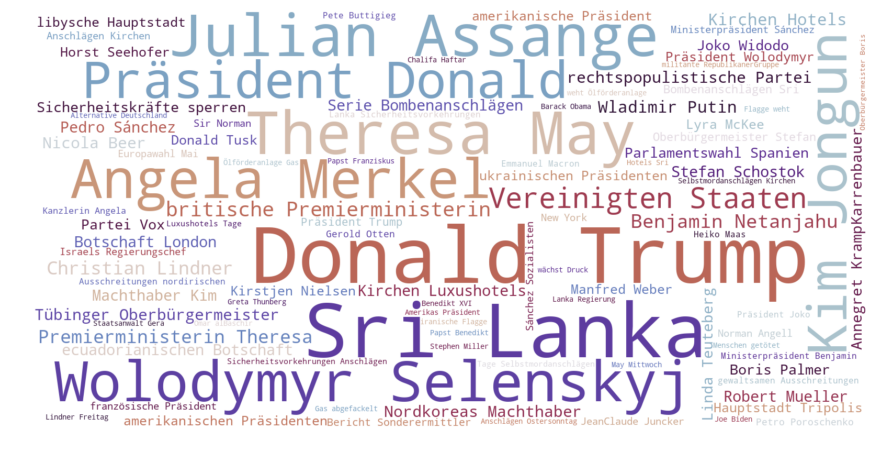

In [36]:
utils.get_wordcloud(pol_text, stopwordlist)

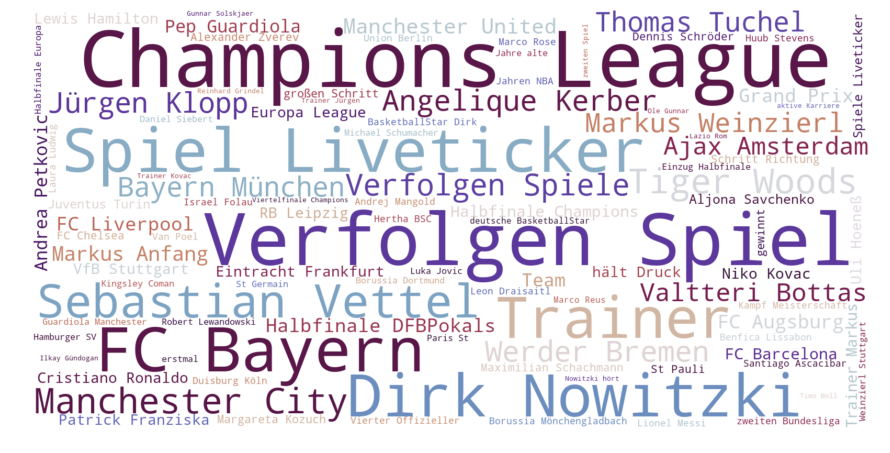

In [37]:
utils.get_wordcloud(sport_text, stopwordlist)

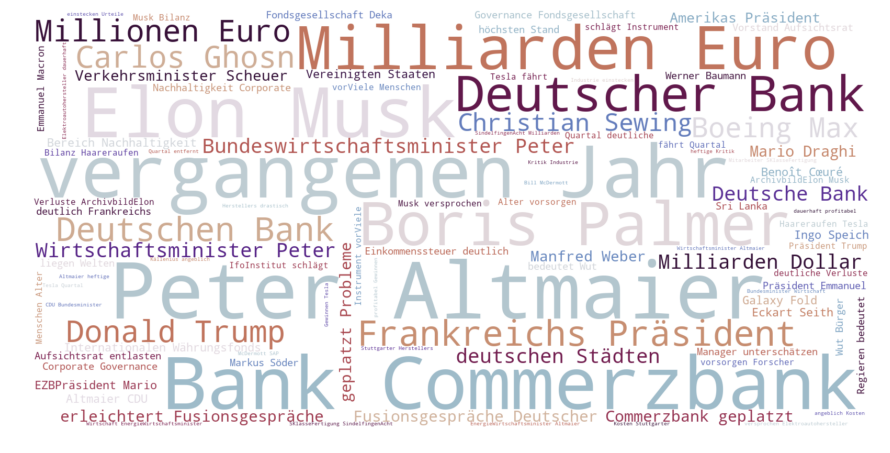

In [38]:
utils.get_wordcloud(eco_text, stopwordlist)

---

### Randomly generate a text to test the model:

In [42]:
sample = []

samples = utils.test_tables('aktuell')
sample.append(samples)

faz_sample = pd.concat(sample, axis=0, ignore_index=True)
faz_sample = faz_sample.drop_duplicates()

In [43]:
faz_samples = faz_sample.drop(columns=['link', 'published','title','label'])
details = faz_samples['detailed']
sample_text = details.values.tolist()

In [46]:
sample = random.choice(sample_text)
print(sample)
print('\n')

exemp = sample.lower()
test_article = tf_vector.transform([exemp])
prediction = lclf.predict(test_article)

utils.print_classification(prediction)

Gibt in Turin den Takt vor: Juventus-Profi Cristiano RonaldoJuventus Turin hat sein sportliches Schicksal ganz bewusst aus der Hand gegeben: Der Klub hat sich einzig Cristiano Ronaldo anvertraut. Deshalb kommen nun Fragen auf – doch die Italiener geben eine klare Antwort.


The above text belongs to the category: "Sport"


---
### alternatively: Copy and paste your text below:

In [39]:
txt = 'Der bayerische AfD-Landtagsabgeordnete Franz BergmüllerDer bayerische AfD-Fraktionschef will seinen Posten aufgeben und wohl auch aus der Partei austreten. Im  F.A.Z.-Interview fordert sein Parteifreund Franz Bergmüller von der Bayern-AfD eine „klare Selbstreflexion“ – und Konsequenzen'

In [40]:
ex = txt.lower()
test_art = tf_vector.transform([ex])
pre = lclf.predict(test_art)

print(utils.print_classification(pre))

The above text belongs to the category: "Politik"
None


---